<a href="https://colab.research.google.com/github/khangtrn/DC-Take-home-challenge/blob/main/DC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries


In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, dot, concatenate, Flatten
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Read data
due to some mistake, a column call "Unnamed: 0" is created, we just need to delete it

In [274]:
# Read movies data
movies_df = pd.read_csv('movies.csv')
# Read ratings data
ratings_df = pd.read_csv('ratings.csv')
del ratings_df['Unnamed: 0']
movie = ratings_df['movieId'].unique()

# Split dataset for training: X preresent user ID and movie ID, Y preresent rating

In [275]:
X = ratings_df.iloc[:,:2]
Y = ratings_df.iloc[:,2]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 66)

# Create model with Embedding layer and Dot product
Jeremy Howard provides a general rule of thumb about the number of embedding dimensions: embedding size = min(50, number of categories/2)

In [277]:
# the number of embedding dimensions: embedding size = min(50, number of categories/2)
embedding_dimension = 50

# no of users and movies
n_users = ratings_df['userId'].nunique()
n_movies = ratings_df['movieId'].nunique()
user_input = Input(shape=(1,))
user_embeddings = Embedding(input_dim = n_users + 1, output_dim=embedding_dimension, input_length=1,
                              name='User_Embedding') (user_input)
user_vector = Flatten(name='User_Vector') (user_embeddings)


# Movie Embeddings
movie_input = Input(shape=(1,))
movie_embeddings = Embedding(input_dim = n_movies + 1, output_dim=embedding_dimension, input_length=1,
                               name='Movie_Embedding') (movie_input)
movie_vector = Flatten(name='Movie_Vector') (movie_embeddings)


# Dot Product
merged_vectors = dot([user_vector, movie_vector], axes=1)
model = Model([user_input, movie_input], merged_vectors)
model.compile(loss='mean_squared_error', optimizer = 'Adam')

# Train model

In [278]:
batch_size = 128
epochs = 10
history = model.fit(x=[x_train['userId'], x_train['movieId']], y=y_train, batch_size= batch_size, epochs=epochs,
                    verbose= 2, validation_data=([x_test['userId'], x_test['movieId']], y_test))

Epoch 1/10
631/631 - 8s - loss: 12.3071 - val_loss: 7.7360 - 8s/epoch - 12ms/step
Epoch 2/10
631/631 - 6s - loss: 3.8194 - val_loss: 2.3262 - 6s/epoch - 10ms/step
Epoch 3/10
631/631 - 6s - loss: 1.6089 - val_loss: 1.6240 - 6s/epoch - 9ms/step
Epoch 4/10
631/631 - 6s - loss: 1.0830 - val_loss: 1.3907 - 6s/epoch - 9ms/step
Epoch 5/10
631/631 - 6s - loss: 0.8405 - val_loss: 1.2934 - 6s/epoch - 10ms/step
Epoch 6/10
631/631 - 6s - loss: 0.7012 - val_loss: 1.2462 - 6s/epoch - 9ms/step
Epoch 7/10
631/631 - 7s - loss: 0.6110 - val_loss: 1.2283 - 7s/epoch - 11ms/step
Epoch 8/10
631/631 - 6s - loss: 0.5495 - val_loss: 1.2246 - 6s/epoch - 10ms/step
Epoch 9/10
631/631 - 6s - loss: 0.5029 - val_loss: 1.2211 - 6s/epoch - 10ms/step
Epoch 10/10
631/631 - 6s - loss: 0.4639 - val_loss: 1.2271 - 6s/epoch - 9ms/step


# Plot Loss Curves

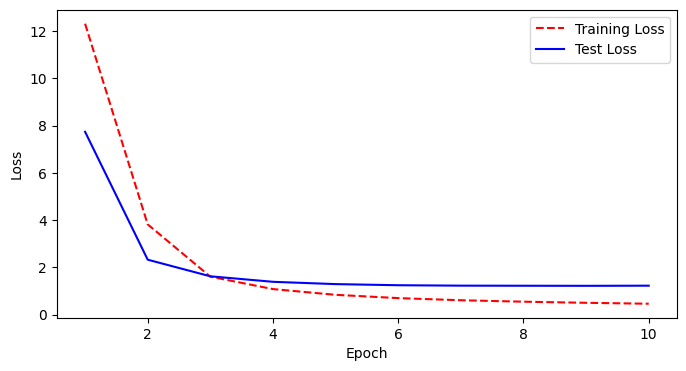

In [279]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.figure(figsize = (8,4))
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Evaluate with Root Mean Square Error

In [280]:
score = model.evaluate([x_test['userId'], x_test['movieId']], y_test)
print()
print('RMSE: {:.4f}'.format(np.sqrt(score)))

631/631 [==============================] - 1s 1ms/step - loss: 1.2271

RMSE: 1.1077


# Generate the personalized recommendations

In [281]:
user_id = np.array(int(input('User ID from 1 to 610: ')))
moive_seen_idx =  ratings_df[ (ratings_df['userId']==user_id) ].index
moive_seen = []
movies_to_predict =  []
for idx in moive_seen_idx:
  moive_seen.append(ratings_df['movieId'][idx])
for movie_id in movie:
  if movie_id not in np.array(moive_seen):
    movies_to_predict.append(movie_id)

user_id_to_predict = np.array([user_id] * len(movies_to_predict))

# Prepare the movie IDs for prediction
movie_ids_to_predict = np.array(movies_to_predict)

# Predict using the model
predicted_ratings = model.predict([user_id_to_predict, movie_ids_to_predict])

# Combine movie IDs with their predicted ratings
movie_predictions = list(zip(movies_to_predict, predicted_ratings))

# Sort predictions based on predicted ratings
sorted_predictions = sorted(movie_predictions, key=lambda x: x[1], reverse=True)
# Print top 10 recommendations
print(f"Top recommendations for user #{user_id}:")
for movie_id, predicted_rating in sorted_predictions[:10]:
    print(f"Movie: {movies_df.loc[movie_id-1].title}")

User ID from 1 to 610: 610
264/264 [==============================] - 1s 2ms/step
Top recommendations for user #610:
Movie: Lonely Are the Brave (1962)
Movie: Airplane! (1980)
Movie: Sydney White (2007)
Movie: Where the Day Takes You (1992)
Movie: I Know Where I'm Going! (1945)
Movie: Safety of Objects, The (2001)
Movie: Brice Man, The (Brice de Nice) (2005)
Movie: Julien Donkey-Boy (1999)
Movie: The Road Within (2014)
Movie: Brown Bunny, The (2003)
